In [17]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.linear_model import Lasso, Ridge

In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import openml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [37]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [ ]:
data = pd.read_csv("./train.csv")
subspures = pd.read_csv("./substances.csv")
pure_heroin = subspures[(subspures['substance'] == 'heroin (white)') | (subspures["substance"]=="heroin (brown)")]

In [ ]:
from scipy.spatial.distance import cdist
distances = cdist(data.iloc[:,6:].to_numpy(), pure_heroin.iloc[:, 1:].to_numpy(), metric = 'euclidean')
dist_her = pd.DataFrame(distances, index = data.iloc[:,6:].index, columns=pure_heroin.iloc[:,1:].index)

In [51]:
#normalized_data = preprocessing.normalize(data.iloc[:, 6:].values)
#normalized_substances = preprocessing.normalize(subspures.iloc[:,1:].values)
data_new_features2 = data.iloc[:, 6:].values.dot(subspures.iloc[:,1:].values.T)

In [43]:
spectrum = data.iloc[:, 6:]
spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
spectrum_filtered_st = zscore(spectrum_filtered, axis = 1)

X = data_new_features2
y = data['PURITY']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

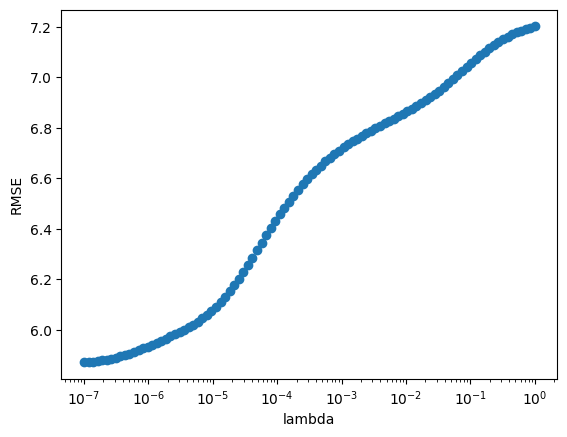

In [55]:
model = Ridge() #ridge regressors model
param_grid = {'alpha': np.logspace(-7, 0, 100)} #hyperparamater alpha

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

mach1 = grid_search.best_estimator_ #best model
mach1.fit(X_train, y_train) #apply the best model to the data
predictions = mach1.predict(X_valid)

plt.figure()
plt.scatter(np.logspace(-7, 0, 100),        
            np.sqrt(-grid_search.cv_results_['mean_test_score']))
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.xscale("log")
plt.show()

In [56]:
mach1.get_params()

{'alpha': 1e-07,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [57]:
y_pred1 = mach1.predict(X_train)
y_pred2 = mach1.predict(X_valid)
train_score = np.mean(np.abs(y_pred1-y_train<=5))
test_score = np.mean(np.abs(y_pred2-y_valid<=5))
print("Train score ridge :", train_score)
print("Test score ridge :", test_score)

Train score ridge : 0.8502024291497976
Test score ridge : 0.7538461538461538
